In [1]:
from sinergym_wrapper import SinergymWrapper
from epw_scraper.epw_data import EPW_Data
from utils import *
import numpy as np
import pandas as pd

weather_var_names = ['drybulb', 'relhum',
                        "winddir", "dirnorrad", "difhorrad"]
weather_var_rev_names = ["windspd"]

epw_data = EPW_Data.load("epw_scraper/US_epw_OU_data.pkl")
# We only need to include the default evaluation variability since we'll sample the rest later
weather_var_config = get_variability_configs(
    weather_var_names, weather_var_rev_names, epw_data=epw_data)

weather_variabilities = []
for row, pca in zip(epw_data.epw_df.iterrows(), epw_data.transformed_df.iterrows()):
    row = row[1]
    pca = pca[1]
    weather_params = {}
    for variable in weather_var_names + weather_var_rev_names:
        OU_param = np.zeros(3)
        for j in range(3):
            OU_param[j] = np.array(row[f"{variable}_{j}"]).squeeze().item()
        weather_params[variable] = OU_param
    weather_variabilities.append(weather_params)

env_config = {
    # sigma, mean, tau for OU Process
    "weather_variability": weather_variabilities,
    "variability_low": weather_var_config["train_var_low"],
    "variability_high": weather_var_config["train_var_high"],
    "use_rbc": False,
    "use_random": False,
    "sample_environments": False,
    "sinergym_timesteps_per_hour": 1
}
env = SinergymWrapper(env_config)

/home/doseok/miniconda3/envs/ActiveRL/lib/python3.10/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/mnt/7076984276980B4C/ssd_backup/ActiveRL/sinergym_wrapper.py:321: DeprecationWarning: getName() is deprecated, get the name attribute instead
  self._thread_name = threading.current_thread().getName()


[2023-02-16 19:49:24,337] EPLUS_ENV_Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681_MainThread_ROOT INFO:Updating idf ExternalInterface object if it is not present...
[2023-02-16 19:49:24,338] EPLUS_ENV_Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681_MainThread_ROOT INFO:Updating idf Site:Location and SizingPeriod:DesignDay(s) to weather and ddy file...
[2023-02-16 19:49:24,339] EPLUS_ENV_Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681_MainThread_ROOT INFO:Updating idf OutPut:Variable and variables XML tree model for BVCTB connection.
[2023-02-16 19:49:24,340] EPLUS_ENV_Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681_MainThread_ROOT INFO:Setting up extra configuration in building model if exists...
[2023-02-16 19:49:24,341] EPLUS_ENV_Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681_MainThread_ROOT INFO:Setting up action definition in building model if exists...


/home/doseok/miniconda3/envs/ActiveRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/doseok/miniconda3/envs/ActiveRL/lib/python3.10/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [2]:
from uncertain_ppo import UncertainPPOTorchPolicy
# agent = UncertainPPO(config={"env_config": env_config, "env": env, "disable_env_checking": True})
agent = UncertainPPOTorchPolicy.from_checkpoint("checkpoints/activerl")["default_policy"]

/home/doseok/miniconda3/envs/ActiveRL/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/mnt/7076984276980B4C/ssd_backup/ActiveRL/dm_maze/dm_wrapper.py:3: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


FullyConnectedNetwork(
  (_logits): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=10, bias=True)
    )
  )
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=38, out_features=256, bias=True)
        (1): Sequential(
          (0): Tanh()
          (1): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Sequential(
          (0): Tanh()
          (1): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)


In [3]:
agent.__dict__.keys()

dict_keys(['framework', '_loss_initialized', 'observation_space', 'action_space', 'observation_space_struct', 'action_space_struct', 'config', 'callbacks', 'global_timestep', 'num_grad_updates', 'dist_class', 'view_requirements', '_model_init_state_automatically_added', 'agent_connectors', 'action_connectors', 'devices', 'device', 'model_gpu_towers', 'model', 'unwrapped_model', '_lock', '_state_inputs', '_is_recurrent', 'exploration', '_optimizers', '_loss', 'multi_gpu_param_groups', '_loaded_batches', 'distributed_world_size', 'batch_divisibility_req', 'max_seq_len', '_value', '_lr_schedule', 'cur_lr', '_entropy_coeff_schedule', 'entropy_coeff', 'kl_coeff', 'kl_target', '_no_tracing', '_dummy_batch', 'num_dropout_evals'])

In [4]:
agent.model = agent.model.to("cuda")

In [5]:

rew_df = {"rew": [], "x": [], "y": []}
bad_idxs = []
for i in range(5):#range(len(weather_variabilities)):
    try:
        pca = epw_data.transformed_df.iloc[i]
        obs = env.reset(i)
        done = False
        avg_rew = 0
        cnt = 0
        while not done:
            action = agent.compute_single_action(obs)[0]
            obs, rew, done, _ = env.step(action)
            avg_rew += rew
            cnt += 1
        rew_df["rew"].append(avg_rew / cnt)
        rew_df["x"].append(pca[0])
        rew_df["y"].append(pca[1])
    except Exception as e:
        bad_idxs.append(i)
        

[2023-02-16 19:49:28,895] EPLUS_ENV_Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-02-16 19:49:29,007] EPLUS_ENV_Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681_MainThread_ROOT INFO:EnergyPlus working directory is in /mnt/7076984276980B4C/ssd_backup/ActiveRL/Eplus-env-Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681-res1/Eplus-env-sub_run1


/home/doseok/miniconda3/envs/ActiveRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:216: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator. 
  logger.warn(
/home/doseok/miniconda3/envs/ActiveRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:228: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/home/doseok/miniconda3/envs/ActiveRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


PRESET VARIABILITY {'drybulb': array([ 7.32890664e+00, -1.46704904e+01,  5.56886516e-03]), 'relhum': array([2.74770835e+01, 1.97655611e+01, 4.16457610e-03]), 'winddir': array([1.20503325e+02, 8.22794702e+00, 4.01096933e-04]), 'dirnorrad': array([ 2.78731385e+02, -3.95705723e+01,  5.97677364e-04]), 'difhorrad': array([6.26395029e+01, 4.83088340e-01, 3.73415552e-04]), 'windspd': array([3.27976588e+00, 2.12826001e+00, 8.49027825e-04])}
[2023-02-16 19:49:31,970] EPLUS_ENV_Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-02-16 19:49:31,971] EPLUS_ENV_Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-02-16 19:49:32,128] EPLUS_ENV_Eplus-5Zone-hot-discrete-stochastic-v1-FlexibleReset1809681_MainThread_ROOT INFO:EnergyPlus working directory is in /mnt/7076984276980B4C/ssd_backup/ActiveRL/Eplus-env-Eplus-5Zone-hot-discrete-stochastic

In [6]:
rew_df = pd.DataFrame.from_dict(rew_df)

/tmp/ipykernel_1809681/3621953069.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rews = np.array(rew_df["rew"][:, None])


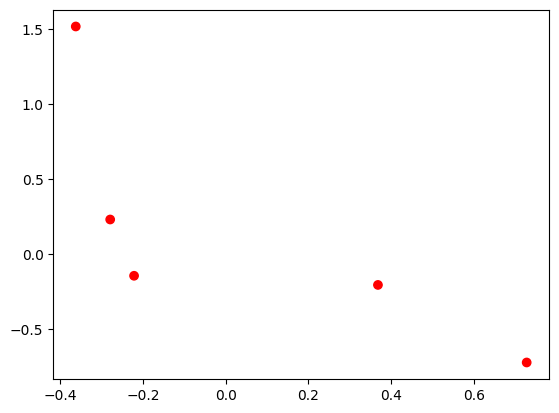

In [7]:
import matplotlib.pyplot as plt
green = np.array([0,0,1])
red = np.array([1,0,0])
rews = np.array(rew_df["rew"][:, None])
plt.scatter(rew_df["x"], rew_df["y"], c=( rews > 0.5) * green + (rews <= 0.5) * red)

In [10]:
rew_df

,rew,x,y
0,-0.455074,-0.362468,1.516681
1,-0.438776,-0.362468,1.516681
2,-0.421518,-0.362468,1.516681
3,-0.424568,-0.362468,1.516681
4,-0.432518,-0.362468,1.516681
